In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser
import os

path_to_results = r'C:\Users\huda\Downloads\\'
#path_to_results = r'/home/dhu/Downloads/results/'

In [2]:
from ast import literal_eval
files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
all_data = dict()
for file in files:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    if file.split('/')[-1][:-4] == 'results_hexaly_rewritten':
        all_data['results_hexaly'] = df
    elif file.split('/')[-1][:-4] == 'results_cplex_lp_rewritten':
         all_data['results_cplex_lp'] = df
    else:
        all_data[file.split('/')[-1][:-4]] = df
del df
del file_content

In [3]:
for key in all_data.keys():
    df = all_data[key]
    df = df[~df['name'].str.startswith('Error')]
    df = df[df['fitness_value'] != float('inf')]
    df.resource_history = df.resource_history.apply(literal_eval)
    all_data[key] = df

In [4]:
def get_comparison(data, instance, column, max = False):
    if max:
        best = -float('inf')
    else:
        best = float('inf')
    for key in data.keys():
        optimizer = data[key]
        if instance in optimizer.name.values:
            fitness = optimizer.loc[optimizer['name'] == instance][column].tolist()[0]
            if max and fitness > best:
                best = fitness
            elif not max and fitness < best:
                best = fitness
    return best

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_cdf_comparison_vector(data : dict, column, max, instances):
    results = []
    for _ in data:
        results.append([])
    for instance in instances:
        best = get_comparison(data, instance, column, max)
        i = 0
        for key in data.keys():
            if not instance in data[key].name.values:
                results[i].append(-float('inf') if max else float('inf'))
            else:
                results[i].append(calculate_value(data[key].loc[data[key]['name'] == instance][column], best).item())
            i += 1
    for result in results:
        if max:
            result.sort(reverse=True)
        else:
            result.sort()
    return results

In [5]:
def ecdf_inf(data, column, max : bool = False, n_instances : int = 402, labels : list[str] = [], instances : list[str] = []):
    vectors = get_cdf_comparison_vector(data, column, max, instances)
    plot_vectors = []
    for vector in vectors:
        plot_vectors.append([[0.0],[0.0]])
        i = 1
        while i < len(vector):
            if vector[i] == float('inf'):
                break
            if vector[i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0].append(vector[i-1])
            plot_vectors[-1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(vectors)):
        plt.plot(plot_vectors[i][0], plot_vectors[i][1], label=[labels[i]])
    if column == 'fitness_value':
        plt.xlim(-0.1, 1.0)
        
    plt.legend()
    plt.title(column)
    plt.show()


In [6]:
instances = os.listdir(r'C:\Users\huda\Downloads\benchmarks_with_workers\benchmarks_with_workers')
#instances = os.listdir(r'/home/dhu/dev/Github/scheduling_model-1/code/reworked_data_model/benchmarks_with_workers')

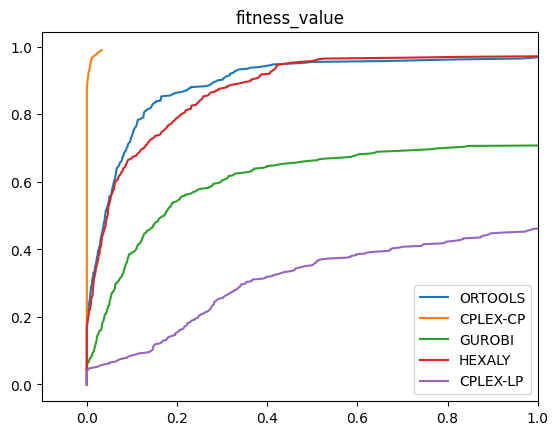

In [7]:
ecdf_inf(all_data, 'fitness_value', labels=['ORTOOLS', 'CPLEX-CP', 'GUROBI', 'HEXALY', 'CPLEX-LP'], instances=instances)

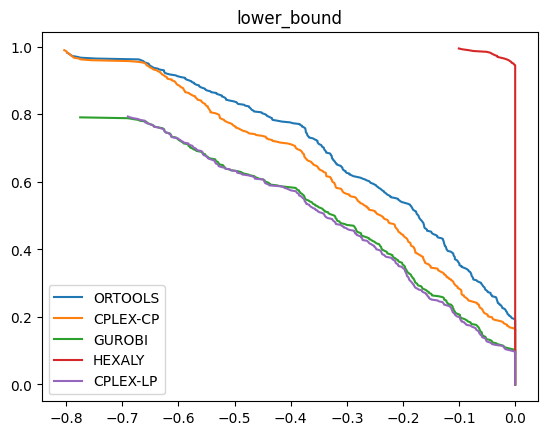

In [8]:
ecdf_inf(all_data, 'lower_bound', max=True, labels=['ORTOOLS', 'CPLEX-CP', 'GUROBI', 'HEXALY', 'CPLEX-LP'], instances=instances) 

In [9]:
all_data['results_hexaly']

KeyError: 'results_hexaly'

In [ ]:
def find_time_vectors(data, distance, column, overall : bool = True):
    if column == 'fitness_value':
        target = min([min(d['resource_history'][1][1]) for d in data])
    else: # lower_bound
        target = max([max(d['resource_history'][2][1]) for d in data])
    target *= (1.0 - distance) if column == 'fitness_value' else (1.0 + distance)
    results = []
    for d in data:
        for t in d['best_result_history']:
            if column == 'fitness_value':
                if not overall:
                    target = d['fitness_value'] * (1.0 - distance)
                if t[1] <= target:
                    results.append(t[0])
                    break
            else:
                if not overall:
                    target = d['lower_bound'] * (1.0 + distance)
                if t[2] >= target:
                    results.append(t[0])
                    break
    return results
        

In [ ]:
in_data = [all_data[key] for key in all_data.keys()]

In [ ]:
len(in_data)

5

In [ ]:
find_time_vectors(in_data, 0.1, 'fitness_value')

KeyError: 1